In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
import os

# Path to dataset
dataset_path = path

# Walk through the directory structure
for root, dirs, _ in os.walk(dataset_path):
    print(f"\n📁 Directory: {root}")
    for d in dirs:
        print(f"   └── 📂 Sub-folder: {d}")



📁 Directory: /kaggle/input/brain-tumor-mri-dataset
   └── 📂 Sub-folder: Training
   └── 📂 Sub-folder: Testing

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training
   └── 📂 Sub-folder: pituitary
   └── 📂 Sub-folder: notumor
   └── 📂 Sub-folder: meningioma
   └── 📂 Sub-folder: glioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/notumor

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/meningioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Training/glioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing
   └── 📂 Sub-folder: pituitary
   └── 📂 Sub-folder: notumor
   └── 📂 Sub-folder: meningioma
   └── 📂 Sub-folder: glioma

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor

📁 Directory: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma

📁 Directory: /kaggle/input/brain-tumor

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set paths
train_dir = f'{path}/Training'
test_dir = f'{path}/Testing'

# Define transforms for training and testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Load dataset using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names and dataset size
print("Classes:", train_dataset.classes)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of training samples: 5712
Number of testing samples: 1311


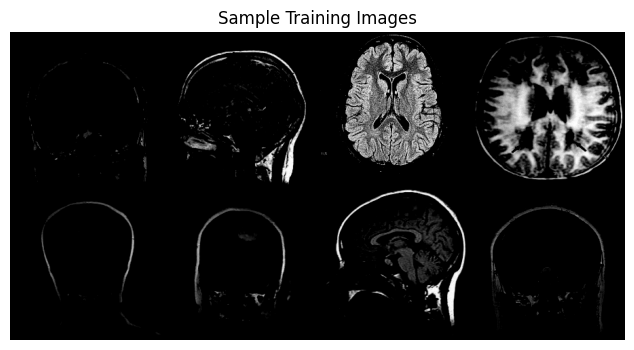

In [4]:
import matplotlib.pyplot as plt
import torchvision

# Get one batch of training images
images, labels = next(iter(train_loader))

# Make a grid of first 8 images
img_grid = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(10, 4))
plt.imshow(img_grid.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
plt.title("Sample Training Images")
plt.axis('off')
plt.show()


In [5]:
import torch
import torch.nn as nn
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Unfreeze all layers (make all parameters trainable)
for param in model.parameters():
    param.requires_grad = True

# Replace the classifier (fc layer) with a custom one
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(256, 4)  # 4 classes output
)


# Move model to device
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


In [6]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (only for trainable parameters)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_acc = 0
    patience = 3       # number of epochs to wait after last improvement
    counter = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        train_acc = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_running_loss / len(val_loader)

        # Append metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            # Save the best model here
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model saved at epoch {epoch+1} with val_acc: {best_val_acc:.2f}%")
        else:
            counter += 1

        if best_val_acc >= 100:  # your accuracy threshold
            print(f"Early stopping: val_acc reached {best_val_acc:.2f}%")
            break

        if counter >= patience:
            print(f"Early stopping: no improvement in {patience} epochs")
            print(f"validation accuracy : {best_val_acc}")
            break

        print(f"Epoch [{epoch+1}/{epochs}] ➜ Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [8]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, epochs=10)


Model saved at epoch 1 with val_acc: 97.48%
Epoch [1/10] ➜ Loss: 0.3343 | Train Acc: 89.81% | Val Acc: 97.48%
Model saved at epoch 2 with val_acc: 98.17%
Epoch [2/10] ➜ Loss: 0.1047 | Train Acc: 97.79% | Val Acc: 98.17%
Epoch [3/10] ➜ Loss: 0.0781 | Train Acc: 98.14% | Val Acc: 96.80%
Model saved at epoch 4 with val_acc: 99.08%
Epoch [4/10] ➜ Loss: 0.0481 | Train Acc: 99.00% | Val Acc: 99.08%
Epoch [5/10] ➜ Loss: 0.0402 | Train Acc: 99.04% | Val Acc: 98.86%
Epoch [6/10] ➜ Loss: 0.0391 | Train Acc: 98.93% | Val Acc: 98.47%
Early stopping: no improvement in 3 epochs
validation accuracy : 99.08466819221968


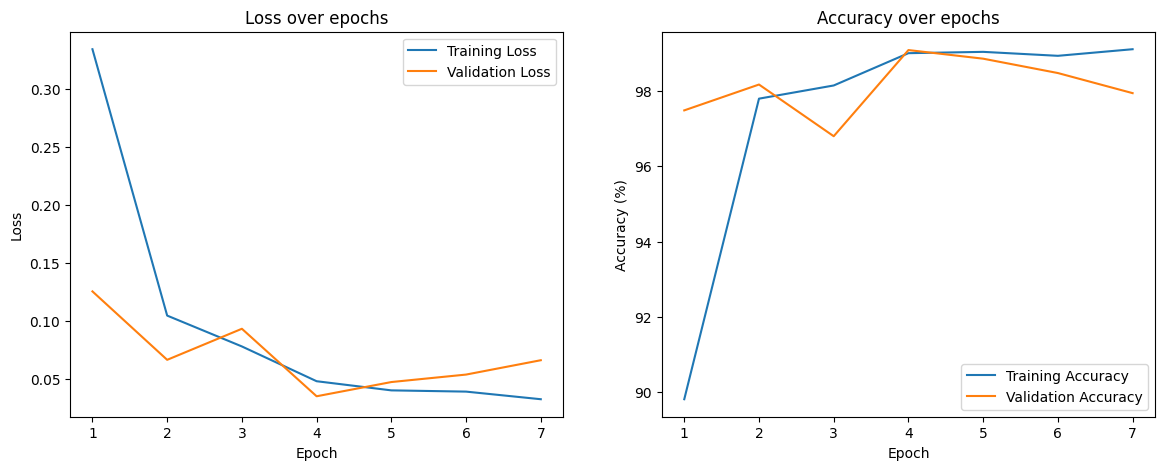

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14,5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


plot_metrics(train_losses, val_losses, train_accs, val_accs)



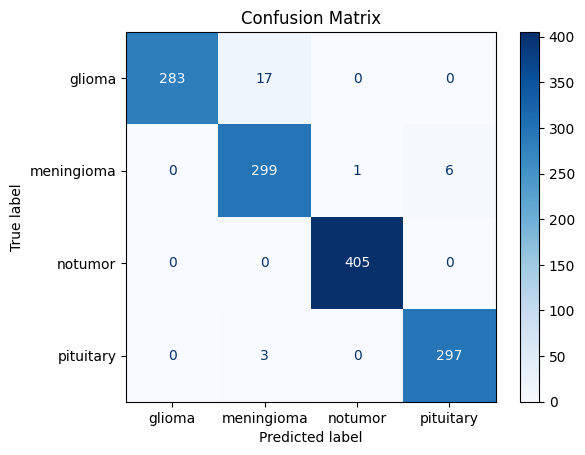

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
plot_confusion_matrix(model, test_loader, device, class_names)
